In [3]:
from dataset import YouCookII
from dataset import collate_fn
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for data in train_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()

            # Run inference (forward pass).            
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        #learning rate schedule
        #update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(num_actions, y, valid_dataloader)
        
        #after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

Epoch 1 - Train Loss: 2511.758056640625, Validation Loss: 2468.366943359375
Epoch 2 - Train Loss: 2289.463623046875, Validation Loss: 1249.776611328125
Epoch 3 - Train Loss: 1232.388427734375, Validation Loss: 1078.2010498046875
Epoch 4 - Train Loss: 974.8031616210938, Validation Loss: 968.9981689453125
Epoch 5 - Train Loss: 885.7230834960938, Validation Loss: 902.5177001953125
Epoch 6 - Train Loss: 882.6370239257812, Validation Loss: 867.4260864257812
Epoch 7 - Train Loss: 847.1033935546875, Validation Loss: 1108.4613037109375
Epoch 8 - Train Loss: 822.4197387695312, Validation Loss: 849.9137573242188


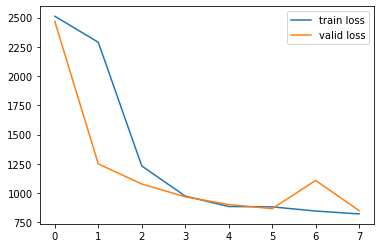

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(device)
#model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/weights"))

train_loss, valid_loss = train(model, 8, 2, epochs=8, lr=1e-5, y=1.0)

In [8]:
import importlib
import visualizer
importlib.reload(visualizer)

import model
importlib.reload(model)

model = model.Model(device)


Epoch 1 - Train Loss: 2798.305419921875, Validation Loss: 2274.94970703125
Epoch 2 - Train Loss: 1649.6707763671875, Validation Loss: 1134.7445068359375
Epoch 3 - Train Loss: 1194.688232421875, Validation Loss: 916.7618408203125
Epoch 4 - Train Loss: 1109.5789794921875, Validation Loss: 910.1710815429688
Epoch 5 - Train Loss: 1097.2620849609375, Validation Loss: 1078.4627685546875
Epoch 6 - Train Loss: 1140.22998046875, Validation Loss: 909.2582397460938
Epoch 7 - Train Loss: 902.1063232421875, Validation Loss: 748.1336669921875
Epoch 8 - Train Loss: 873.5147094726562, Validation Loss: 776.5496215820312
Epoch 9 - Train Loss: 956.8677368164062, Validation Loss: 798.6233520507812
Epoch 10 - Train Loss: 1030.43212890625, Validation Loss: 687.5103149414062
Epoch 11 - Train Loss: 1038.89306640625, Validation Loss: 837.7633666992188
Epoch 12 - Train Loss: 876.7118530273438, Validation Loss: 754.1879272460938
Epoch 13 - Train Loss: 953.1248168945312, Validation Loss: 930.3365478515625
Epoch 1

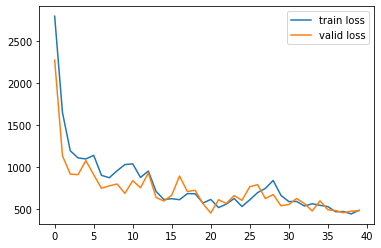

In [9]:
train_loss, valid_loss = train(model, 8, 2, epochs=40, lr=1e-5, y= 1.0)

Action 1: cut the wing at the two joints
-------------------------------
the wing -> Action 8 ([NULL])
the two joints -> Action 8 ([NULL])


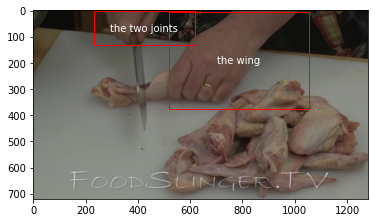

Action 2: mix salt seasoning pepper and baking powder in a bowl
-------------------------------
a bowl -> Action 8 ([NULL])


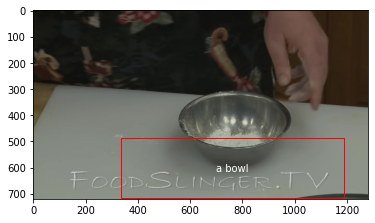

Action 3: coat the wings in the seasoning mix
-------------------------------
the wings -> Action 8 ([NULL])
the seasoning mix -> Action 8 ([NULL])


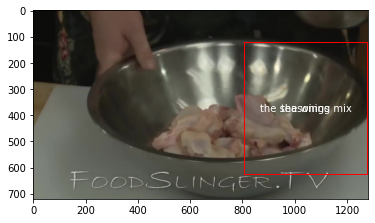

Action 4: cook the wings in the oven
-------------------------------
the wings -> Action 2 (coat the wings in the seasoning mix)
the oven -> Action 8 ([NULL])


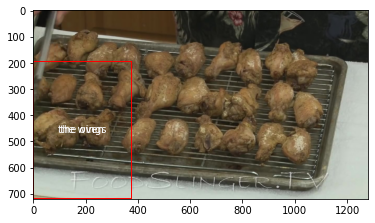

Action 5: flip the wings
-------------------------------
the wings -> Action 3 (cook the wings in the oven)


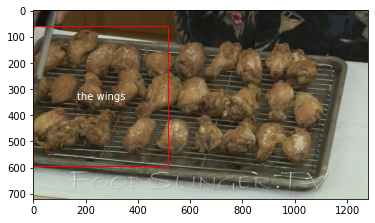

Action 6: cook the wings in the oven
-------------------------------
the wings -> Action 4 (flip the wings)
the oven -> Action 4 (flip the wings)


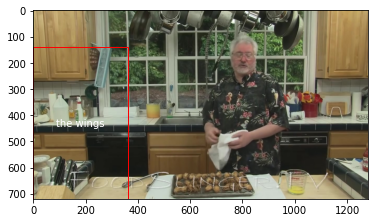

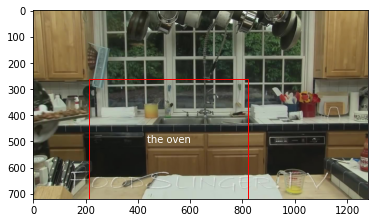

Action 7: mix hot sauce and melted butter together
-------------------------------
hot sauce -> Action 4 (flip the wings)


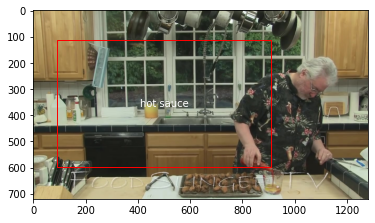

Action 8: coat the wings in sauce
-------------------------------
the wings -> Action 5 (cook the wings in the oven)
sauce -> Action 5 (cook the wings in the oven)


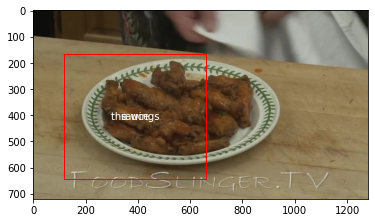

In [7]:
#from visualizer import inference
#POST_TRAINING more
VG, RR = visualizer.inference(model, 8, 40)

Action 1: cut the wing at the two joints
-------------------------------
the wing -> Action 8 ([NULL])
the two joints -> Action 8 ([NULL])


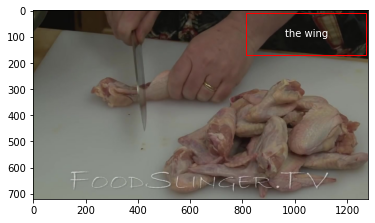

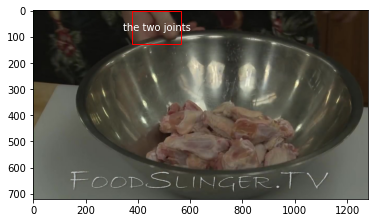

Action 2: mix salt seasoning pepper and baking powder in a bowl
-------------------------------
a bowl -> Action 8 ([NULL])


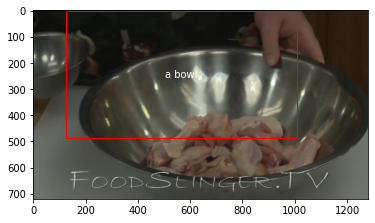

Action 3: coat the wings in the seasoning mix
-------------------------------
the wings -> Action 1 (mix salt seasoning pepper and baking powder in a bowl)
the seasoning mix -> Action 8 ([NULL])


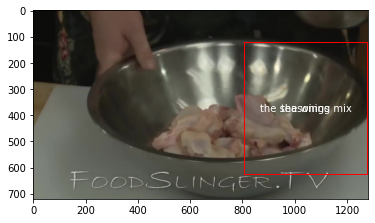

Action 4: cook the wings in the oven
-------------------------------
the wings -> Action 8 ([NULL])
the oven -> Action 8 ([NULL])


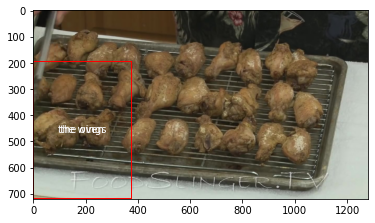

Action 5: flip the wings
-------------------------------
the wings -> Action 3 (cook the wings in the oven)


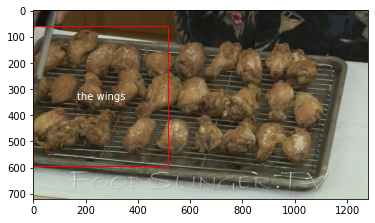

Action 6: cook the wings in the oven
-------------------------------
the wings -> Action 3 (cook the wings in the oven)
the oven -> Action 4 (flip the wings)


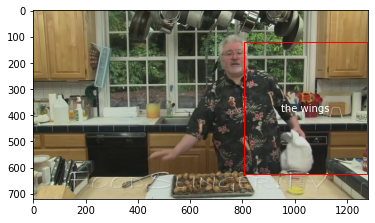

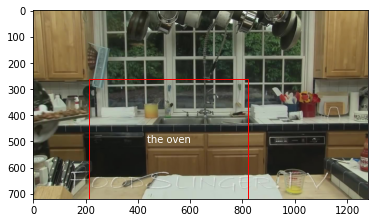

Action 7: mix hot sauce and melted butter together
-------------------------------
hot sauce -> Action 4 (flip the wings)


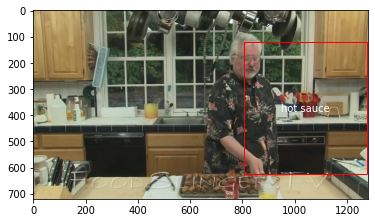

Action 8: coat the wings in sauce
-------------------------------
the wings -> Action 5 (cook the wings in the oven)
sauce -> Action 5 (cook the wings in the oven)


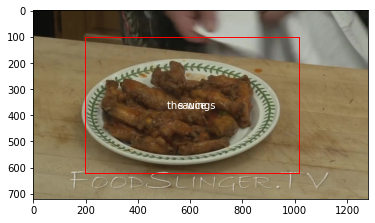

In [5]:
#from visualizer import inference
#POST_TRAINING more
VG, RR = visualizer.inference(model, 8, 40)

Action 1: cut the wing at the two joints
-------------------------------
the wing -> Action 8 ([NULL])
the two joints -> Action 8 ([NULL])


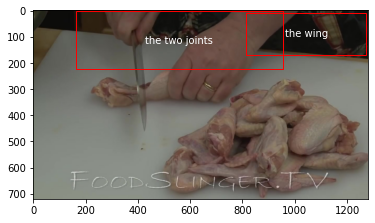

Action 2: mix salt seasoning pepper and baking powder in a bowl
-------------------------------
a bowl -> Action 8 ([NULL])


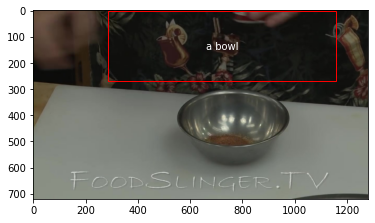

Action 3: coat the wings in the seasoning mix
-------------------------------
the wings -> Action 8 ([NULL])
the seasoning mix -> Action 8 ([NULL])


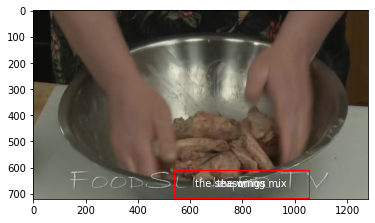

Action 4: cook the wings in the oven
-------------------------------
the wings -> Action 8 ([NULL])
the oven -> Action 8 ([NULL])


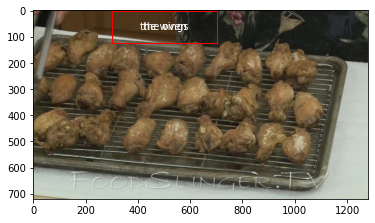

Action 5: flip the wings
-------------------------------
the wings -> Action 3 (cook the wings in the oven)


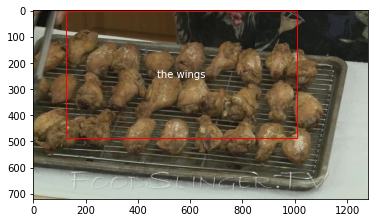

Action 6: cook the wings in the oven
-------------------------------
the wings -> Action 3 (cook the wings in the oven)
the oven -> Action 4 (flip the wings)


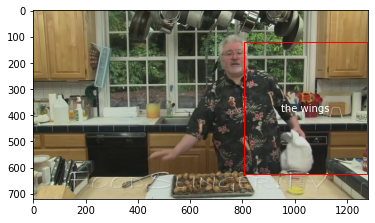

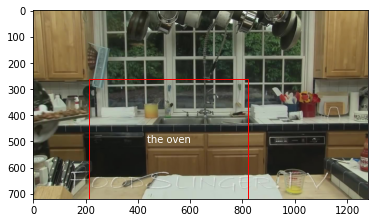

Action 7: mix hot sauce and melted butter together
-------------------------------
hot sauce -> Action 4 (flip the wings)


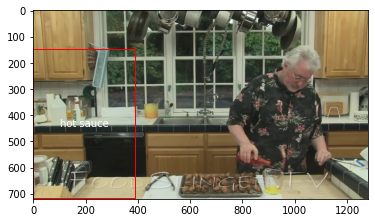

Action 8: coat the wings in sauce
-------------------------------
the wings -> Action 5 (cook the wings in the oven)
sauce -> Action 3 (cook the wings in the oven)


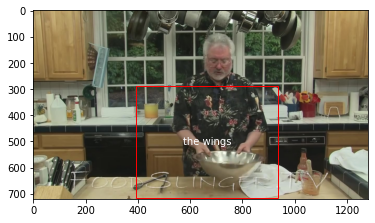

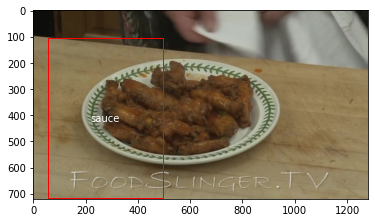

In [23]:
#from visualizer import inference
#POST_TRAINING
VG, RR = visualizer.inference(model, 8, 40)

Action 1: cut the wing at the two joints
-------------------------------
the wing -> Action 8 ([NULL])
the two joints -> Action 8 ([NULL])


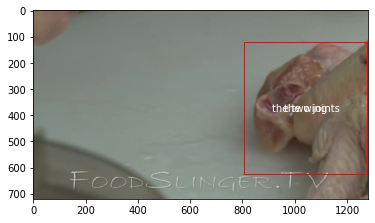

Action 2: mix salt seasoning pepper and baking powder in a bowl
-------------------------------
a bowl -> Action 8 ([NULL])


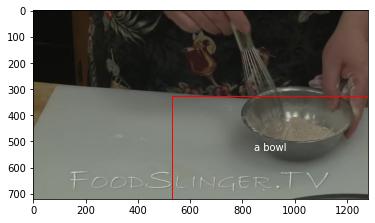

Action 3: coat the wings in the seasoning mix
-------------------------------
the wings -> Action 8 ([NULL])
the seasoning mix -> Action 8 ([NULL])


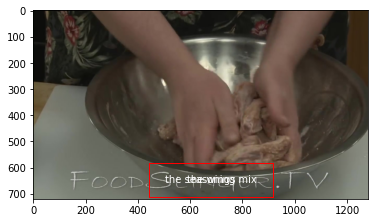

Action 4: cook the wings in the oven
-------------------------------
the wings -> Action 8 ([NULL])
the oven -> Action 8 ([NULL])


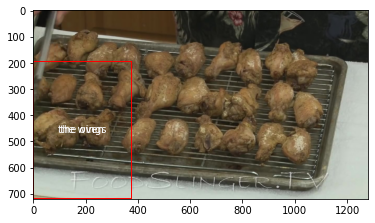

Action 5: flip the wings
-------------------------------
the wings -> Action 8 ([NULL])


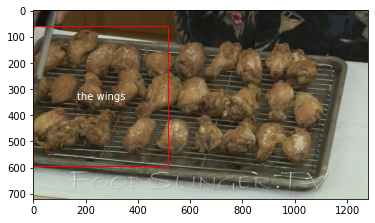

Action 6: cook the wings in the oven
-------------------------------
the wings -> Action 3 (cook the wings in the oven)
the oven -> Action 8 ([NULL])


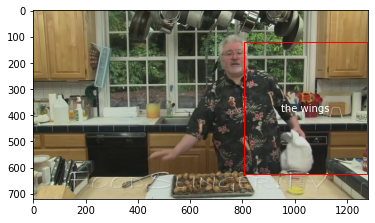

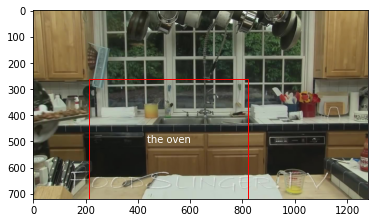

Action 7: mix hot sauce and melted butter together
-------------------------------
hot sauce -> Action 8 ([NULL])


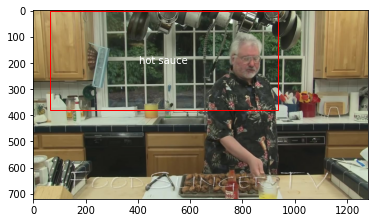

Action 8: coat the wings in sauce
-------------------------------
the wings -> Action 6 (mix hot sauce and melted butter together)
sauce -> Action 8 ([NULL])


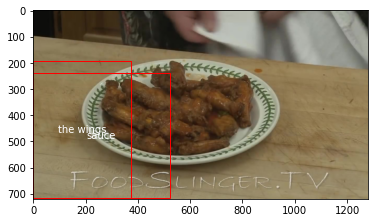

In [19]:
#from visualizer import inference
#PRE_TRAINING
VG, RR = visualizer.inference(model, 8, 40)

In [24]:
#post_training
VG

tensor([[21, 35],
        [41, 39],
        [64, 64],
        [87, 87],
        [ 7,  7],
        [16, 42],
        [57, 57],
        [75, 88],
        [99, 99]], device='cuda:0')

In [12]:
#pre_training
VG

tensor([[92, 92],
        [33, 33],
        [12, 12],
        [54, 54],
        [98, 98],
        [18, 18],
        [55, 55],
        [38, 38],
        [54, 54]], device='cuda:0')

In [20]:
VG

tensor([[16, 16],
        [91, 91],
        [56, 56],
        [81, 81],
        [ 1,  1],
        [16, 42],
        [ 6, 79],
        [81, 80],
        [99, 99]], device='cuda:0')

In [9]:
VG

tensor([[65, 65],
        [93, 50],
        [34, 34],
        [82, 82],
        [15, 37]], device='cuda:0')

In [12]:
torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/weights")